In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [17]:
img_size = 224
batch_size = 32

train_dir = r'D:\Senior_WorkTable\GrowQuest_Data_Final\train'
val_dir = r'D:\Senior_WorkTable\GrowQuest_Data_Final\val'
test_dir = r'D:\Senior_WorkTable\GrowQuest_Data_Final\test' 

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4199 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [18]:
# --- Base Model ---
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model
base_model.trainable = False

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_mobilenetv3_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [20]:
# Unfreeze for fine-tuning
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/20
132/132 [==============================] - ETA: 0s - loss: 4.1747 - accuracy: 0.3720 - precision_1: 0.3746 - recall_1: 0.3382
Epoch 1: val_loss improved from inf to 3.42813, saving model to best_mobilenetv3_model.h5
132/132 [==============================] - 190s 1s/step - loss: 4.1747 - accuracy: 0.3720 - precision_1: 0.3746 - recall_1: 0.3382 - val_loss: 3.4281 - val_accuracy: 0.4544 - val_precision_1: 0.4915 - val_recall_1: 0.3533 - lr: 1.0000e-05
Epoch 2/20
132/132 [==============================] - ETA: 0s - loss: 3.9472 - accuracy: 0.4268 - precision_1: 0.4389 - recall_1: 0.3980
Epoch 2: val_loss improved from 3.42813 to 3.41357, saving model to best_mobilenetv3_model.h5
132/132 [==============================] - 180s 1s/step - loss: 3.9472 - accuracy: 0.4268 - precision_1: 0.4389 - recall_1: 0.3980 - val_loss: 3.4136 - val_accuracy: 0.4956 - val_precision_1: 0.5153 - val_recall_1: 0.4122 - lr: 1.0000e-05
Epoch 3/20
132/132 [==============================] - ETA: 0s - 

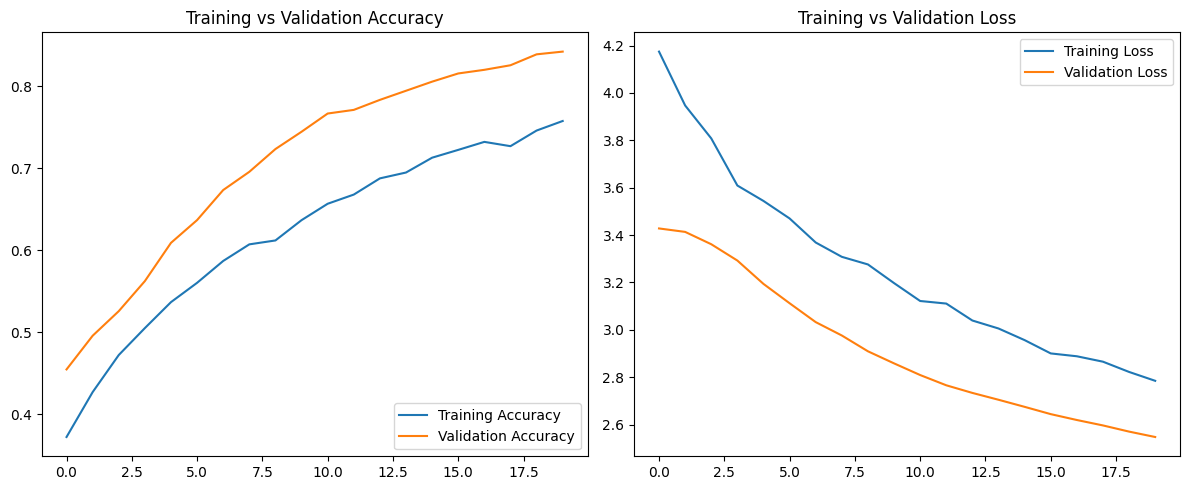

In [22]:
import matplotlib.pyplot as plt

# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()
